<a href="https://colab.research.google.com/github/idribeir0/sao-paulo-election-debate-comments/blob/main/debate_sp_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["YOUTUBE_API_KEY"] = "sua_chave_api"

In [2]:
from googleapiclient.discovery import build
import os

importando bibliotecas e conectando com a chave da API

In [3]:
api_key = os.getenv("YOUTUBE_API_KEY")
youtube = build('youtube', 'v3', developerKey=api_key)

função para buscar comentários

In [4]:
def get_comments(video_id, max_comments=100):
  results = youtube.commentThreads().list(
      part="snippet",
      videoId=video_id,
      maxResults=max_comments,
      textFormat="plainText"
  ).execute()

  comments = []

  for item in results['items']:
    comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
    comments.append(comment)

  return comments

testando a função com o id do vídeo escolhido (nesse caso, o do debate para prefeito de SP na tv gazeta)

In [5]:
video_id = "OmrVKEO8DMQ"
comments = get_comments(video_id, max_comments=100)

print(comments[:5])

['Os jornalistas dizendo que nada justifica a violência. Mas a todo tempo tentam justificar kkkkk', 'Piada essa mídia! 🤣 \nDe longe da para dar uma chance pra esse tal de Marçal, só analisar que o cara já é super rico e não vai precisar roubar igual os outros que nem em suas próprias vidas tem sucesso, quem dirá com uma caneta de poder em suas mãos! Só tem uma pequena chance de ele ir para o segundo turno pois ainda tem muito brasileiro com falta de q.i que ainda estariam em dúvida com relação ao outros personagens! Mais de longe ele é o menos Pior! 🤣🤦🏻\u200d♂️', 'Isso mesmo Marçal tá certo', 'Pablo Prefeito de São Paulo no 1 turno em nome de Jesus amém já é real FAZ O M', '1:56:28 🪑']


fazendo a função que limpa os comentarios

In [8]:
import re
from unidecode import unidecode


def clean_comment(text):
  text = re.sub(r"http\S+", "", text)
  text = re.sub(r"[^\w\s.,?!]", "", text)
  text = unidecode(text)
  text = text.lower()
  return text

testando a função

In [9]:
clean_comments = [clean_comment(comment) for comment in comments]

print(clean_comments[:5])

['os jornalistas dizendo que nada justifica a violencia. mas a todo tempo tentam justificar kkkkk', 'piada essa midia!  \nde longe da para dar uma chance pra esse tal de marcal, so analisar que o cara ja e super rico e nao vai precisar roubar igual os outros que nem em suas proprias vidas tem sucesso, quem dira com uma caneta de poder em suas maos! so tem uma pequena chance de ele ir para o segundo turno pois ainda tem muito brasileiro com falta de q.i que ainda estariam em duvida com relacao ao outros personagens! mais de longe ele e o menos pior! ', 'isso mesmo marcal ta certo', 'pablo prefeito de sao paulo no 1 turno em nome de jesus amem ja e real faz o m', '15628 ']


criando lista de palavras positivas e negativas

In [79]:
positive_words = [
    "fantástica", "ótimo", "excelente", "maravilhoso", "incrível", "bom", "melhor", "apoiar", "feliz", "grande",
    "forte", "inteligente", "sensacional", "brilhante", "gostei", "impressionante", "honesto", "justo", "parabens", "certo"
]
negative_words = [
    "imbecil", "palhaço", "horrível", "péssimo", "lixo", "ruim", "mentiroso", "fraude", "burro", "vergonhoso",
    "ridículo", "lamentável", "insuportável", "idiota", "mentira", "corrupto", "nojento", "sujo", "piada", "absurdo", "ladrao", "deboche", "palhaco", "roubar", "pior"
]


removendo stopwords

In [80]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

custom_stopwords = {"não", "pra", "vai", "ainda", "outros", "os", "vai", "caro", "pois", "como", "que"}
stop_words.update(custom_stopwords)

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


criando a funcao que analisa o sentimento de cada comentario com base na polaridade

In [81]:


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
  text_clean = remove_stopwords(text.lower())

  for word in positive_words:
        if word in text_clean:
            return "Positivo"

  scores = analyzer.polarity_scores(text_clean)

  if scores['compound'] >= 0.05:
    return "Positivo"
  elif scores['compound'] <=0.05:
    return "Negativo"
  else: return "Neutro"

aplicando a nalise de sentimentos nos comentarios

In [82]:
vader_sentiments = [get_vader_sentiment(comment) for comment in clean_comments]

print(vader_sentiments[:5])

['Negativo', 'Positivo', 'Positivo', 'Negativo', 'Negativo']


contando a quantidade de cada tipo de sentimento

In [83]:
from collections import Counter

sentiment_counts = Counter(vader_sentiments)

print(sentiment_counts)

Counter({'Negativo': 89, 'Positivo': 11})


visualizando a distribuicao com um grafico de barras

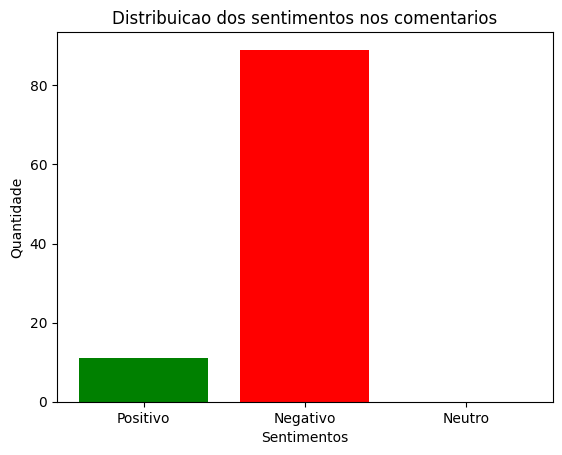

In [84]:
import matplotlib.pyplot as plt

sentiment_labels = ['Positivo', 'Negativo', 'Neutro']
sentiment_counts_ordered = [sentiment_counts.get('Positivo', 0), sentiment_counts.get('Negativo', 0), sentiment_counts.get('Neutro', 0)]

plt.bar(sentiment_labels, sentiment_counts_ordered, color=['green', 'red', 'gray'])
plt.title("Distribuicao dos sentimentos nos comentarios")
plt.xlabel("Sentimentos")
plt.ylabel("Quantidade")
plt.show()

criando a funcao de nuvem de palavras

In [85]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(text, title):
  wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.title(title, size=15)
  plt.axis("off")
  plt.show()

gerando a nuvem de palavras para comentarios positivos

Nuvem de Palavras - Comentários Positivos


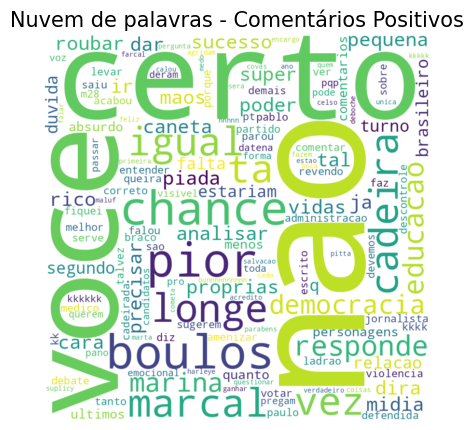

In [86]:
positive_comments = " ".join([remove_stopwords(comment) for comment in clean_comments if get_vader_sentiment(comment) == "Positivo"])
print("Nuvem de Palavras - Comentários Positivos")
plot_wordcloud(positive_comments, "Nuvem de palavras - Comentários Positivos")

gerando a nuvem de palavras para comentarios negativos

Nuvem de Palavras - Comentários Negativos


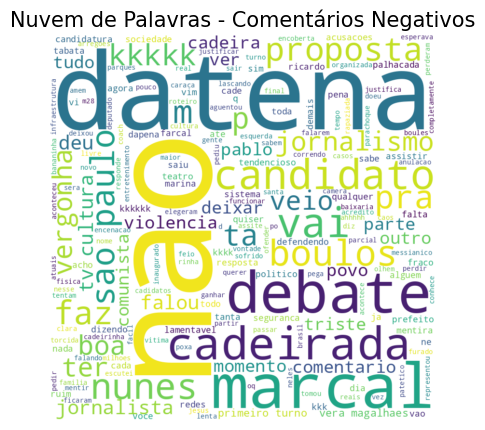

In [87]:
negative_comments = " ".join([comment for comment in clean_comments if get_vader_sentiment(comment) == "Negativo"])
print("Nuvem de Palavras - Comentários Negativos")
plot_wordcloud(negative_comments, "Nuvem de Palavras - Comentários Negativos")

funcao para pegar os scores de vader sem classificar e aplicar o vader para todos os comentarios

In [88]:
def get_vader_score(text):
    text_lower = text.lower()

    for word in negative_words:
        if word in text_lower:
            return -1.0
    for word in positive_words:
        if word in text_lower:
            return 1.0

    scores = analyzer.polarity_scores(text)
    return scores['compound']

encontrando os 5 comentarios mais positivos

In [94]:
comments_with_scores = [(comment, get_vader_score(comment)) for comment in clean_comments]

most_positive_comments = sorted(comments_with_scores, key=lambda x: x[1], reverse=True)[:5]
print("Comentarios mais positivos:")
for comment, score in most_positive_comments:
  print(f"Comentário: {comment} | Score: {score}")

Comentarios mais positivos:
Comentário: marcal ta certo | Score: 1.0
Comentário: boulos responde correto sobre educacao, administracao pt acabou educacao boulos, voce falou porque nao devemos votar voce, certo? | Score: 1.0
Comentário: parabens marina, vez calou boca farcal | Score: 1.0
Comentário: marina responde certo primeira pergunta | Score: 1.0
Comentário: parou ver debate pablo saiu like | Score: 0.3612


encontrando os 5 comentarios mais negativos

In [95]:
negative_comments = [comment for comment in clean_comments if get_vader_sentiment(comment) == "Negativo"]
print(f"Total de comentários negativos: {len(negative_comments)}")
for comment in negative_comments[:5]:
  print(f"Comentário: {comment}")

Total de comentários negativos: 89
Comentário: jornalistas dizendo nada justifica violencia. todo tempo tentam justificar kkkkk
Comentário: pablo prefeito sao paulo 1 turno nome jesus amem ja real faz m
Comentário: 15628
Comentário: ta pra casos familia kkk nao esperava tanta baixaria candidatos santa clara deus livre, nao falando so datena coach messianico.
Comentário: 156 28
